In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
from matplotlib.font_manager import _rebuild
_rebuild()

In [2]:


from conf import SEPS
from utils import get_word_num, GetPara, GetCategoryWeight, print_lis, print_dict
import utils
import conf
reload(conf)
reload(utils)


<module 'utils' from 'utils.pyc'>

In [3]:
data = pd.read_csv('/Users/bytedance/LearningProjects/practice_shouqianba/doctor_essay/politics_doc.csv')

In [4]:
data.columns = [
    'a1', 'a2', 'title', 'a3', 'topic', 'publisher', 'finish_date', 
    'id', 'publish_date', 'keyword', 'url', 'content', 'word_num', 'has_attachment', 
    'a5', 'is_han', 'a7'   
]

In [5]:
data = data.fillna('', inplace=False)
is_han_ori_isna = np.where(data['is_han'] == '')[0]
data['is_han'][is_han_ori_isna] = [0.0] * len(is_han_ori_isna)

/Users/bytedance/miniconda3/envs/tf1/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
data.columns

Index([u'a1', u'a2', u'title', u'a3', u'topic', u'publisher', u'finish_date',
       u'id', u'publish_date', u'keyword', u'url', u'content', u'word_num',
       u'has_attachment', u'a5', u'is_han', u'a7'],
      dtype='object')

In [7]:
data = data[data['is_han'] == 0]
data = data[data['content'] != '']
# sum(data['is_han'])
data.index = np.array([
    i for i in range(data.shape[0])
])

In [8]:
is_renyuan = []
for _ in data['title'] :
    if '组成人员' in _:
        is_renyuan.append(1)
    else:
        is_renyuan.append(0)

data['is_renyuan'] = is_renyuan

In [9]:
data = data[data['is_renyuan'] == 0]
data.index = np.array([
    i for i in range(data.shape[0])
])

In [10]:
data.shape

(3084, 18)

In [ ]:
#============================ 读规则

In [2]:
import pandas as pd
rule_csv = pd.read_csv(
    '/Users/bytedance/LearningProjects/practice_shouqianba/doctor_essay/politics_doc_category_rule.csv'
)
rule_csv.columns = ['category_root', 'category', 'keywords']
category_to_keywords = {}
for idx, row in rule_csv.iterrows():
    category_to_keywords.update({
        row['category']:filter(None, row['keywords'].strip().split(' '))
    })

In [ ]:
#============================ 校验数据

In [8]:
# 查看na
sum(np.array(data.isnull().values.tolist()))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
for i in range(5):
    print len(data.loc()[i]['content']) / 3, data.loc()[i]['word_num']

0 12774.0
3281 3300.0
5250 5317.0
6316 6342.0
6915 6951.0


In [54]:
data.shape

(5712, 17)

In [ ]:
#========================== 处理与计算
# =============== 1. 对每篇内容分段 & merge段落
# =============== 2. 对每个领域计算权重

In [12]:
content_paragraph = []
para_getter = GetPara(merge_word_num=40)

In [13]:
para_list = []
para_word_num = []
para_num = []

In [14]:
for content in data['content']:
    para_s_ = para_getter.get_para_lis(content)
    para_s = para_getter.merge_para(para_s_)

    word_num = [get_word_num(para) for para in para_s]
    
    para_list.append(para_s)
    para_num.append(len(para_s))
    
    para_word_num.append(word_num)
    

In [15]:
word_num_one_lis = []
for _ in para_word_num:
    word_num_one_lis += _

In [16]:
weight_getter = GetCategoryWeight(category_to_keywords=category_to_keywords)

In [ ]:
### only once

In [149]:
weight_lis = []

for _ in para_list:
    weight_str = json.dumps(
        weight_getter.get_category_weight(_)
    )
    weight_lis.append(weight_str)


In [159]:
data['category_weight'] = weight_lis

In [162]:
data.to_csv(
    '/Users/bytedance/LearningProjects/practice_shouqianba/doctor_essay/politics_doc_with_weight.csv'
    ,index=False, encoding='utf_8_sig')

In [ ]:
#======================= 权重矩阵

In [3]:
data_weight = pd.read_csv(
    '/Users/bytedance/LearningProjects/practice_shouqianba/doctor_essay/politics_doc_with_weight.csv'
)

In [4]:
category_weight = []
for _ in data_weight['category_weight']:
    category_weight.append(json.loads(_))

In [5]:
def get_effective_category(weight, thre = 0.05):
    categories = []
    for key, val in weight.items():
        if val > thre:
            categories.append(key)
    return categories

pair_weight_dict = {}
all_categoris = [_.decode('utf8') for _ in category_to_keywords.keys()]
for _a in all_categoris:
    pair_weight_dict[_a] = {}
    for _b in all_categoris:
        pair_weight_dict[_a][_b] = 0.0

for _one in category_weight:
    cat_lis = get_effective_category(_one, thre=0.05)
    for _a in cat_lis:
        for _b in cat_lis:
            pair_weight_dict[_a][_b] += 1.0

for _a in pair_weight_dict.keys():
    for _b in pair_weight_dict[_a]:
        pair_weight_dict[_a][_b] = pair_weight_dict[_a][_b] * 1.0 / 400

(array([308.,  71.,  31.,  17.,   5.,   5.,   1.,   0.,   2.,   1.]),
 array([ 0.   ,  3.678,  7.356, 11.034, 14.712, 18.39 , 22.068, 25.746,
        29.424, 33.102, 36.78 ]),
 <a list of 10 Patch objects>)

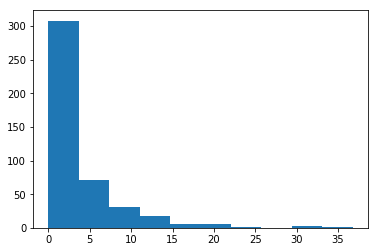

In [9]:
weight_view = []
for _a in pair_weight_dict.keys():
    for _b in pair_weight_dict[_a]:
        weight_view.append(pair_weight_dict[_a][_b])
plt.hist(weight_view)

# 暂定 /50 这个级别

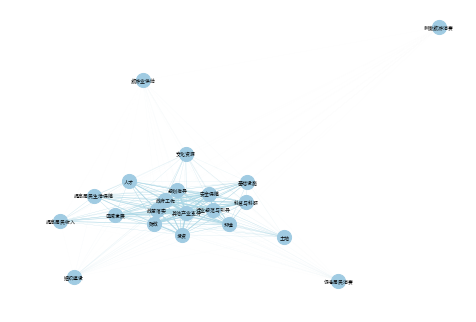

In [6]:
# fig = plt.figure(1, figsize=(200, 80))

G = nx.Graph()#创建空的网络图

for _a in pair_weight_dict.keys():
    for _b in pair_weight_dict[_a]:
        G.add_edge(_a, _b, weight=pair_weight_dict[_a][_b])

options = {
    "node_color": "#A0CBE2",
    "edge_color": "lightblue",
    "width": [G[a][b].get('weight', 0.0) for a,b in G.edges],
    "edge_cmap": plt.cm.Blues,
    "font_family":'SimHei', 
    "font_size": 5,
    "node_size": 200,
}

nx.draw(G, with_labels=True, font_weight='bold',**options)


In [7]:
fig = plt.figure(1, figsize=(500, 200))

<Figure size 36000x14400 with 0 Axes>

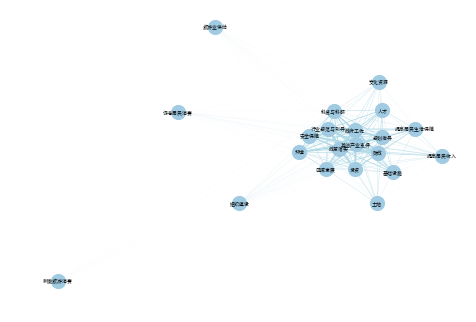

In [8]:
G = nx.Graph()#创建空的网络图

for _a in pair_weight_dict.keys():
    for _b in pair_weight_dict[_a]:
        G.add_edge(_a, _b, weight=pair_weight_dict[_a][_b])

options = {
    "node_color": "#A0CBE2",
    "edge_color": "lightblue",
    "width": [G[a][b].get('weight', 0.0) for a,b in G.edges],
    "edge_cmap": plt.cm.Blues,
    "font_family":'SimHei', 
    "font_size": 5,
    "node_size": 200,
}

nx.draw(G, with_labels=True, font_weight='bold',**options)


(array([1235.,  867.,  543.,  231.,  128.,   35.,   21.,   13.,    7.,
           4.]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <a list of 10 Patch objects>)

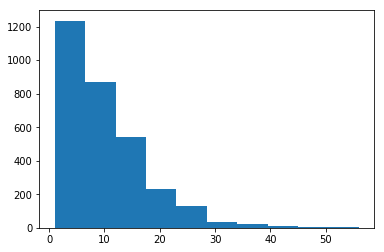

In [35]:
#===================== 自然段数量的分布
plt.hist(para_num)

(array([2.7747e+04, 8.5700e+02, 1.5700e+02, 4.9000e+01, 1.2000e+01,
        7.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([3.0000e+00, 9.4630e+02, 1.8896e+03, 2.8329e+03, 3.7762e+03,
        4.7195e+03, 5.6628e+03, 6.6061e+03, 7.5494e+03, 8.4927e+03,
        9.4360e+03]),
 <a list of 10 Patch objects>)

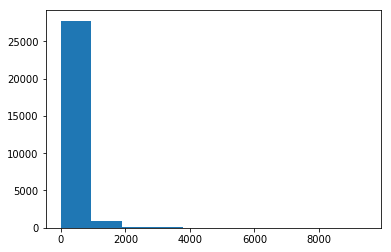

In [36]:
plt.hist(word_num_one_lis)

In [ ]:
交通
财政
财政

1.

1/3  2/3


In [ ]:
人标数据：文本 - 类型  0/1.
文本 - a类型 0~1, B类型 0~1. 归一化: 预估。。这一段一定讲到了

挖掘数据：文本 - a类型，权重

人标注 几百 0/1
挖掘：权重 0/1

In [ ]:
KL

In [ ]:
#============================== 看Case

In [15]:
weight_getter = GetCategoryWeight(category_to_keywords=category_to_keywords)

In [18]:
one_para = para_list[1][0]
weight_getter.debug_one_para_category_weight(one_para, category='环境', only_case=False)

财政 0
人才 0
土地 0
科技与科研 0
旅游业供给 0
组织建设 0
提高居民收入 0
政策落实 0
文化资源 0
刺激旅游消费 0
规划指导 0
投资 0
其他产业支持 0
促进居民消费 0
环境 2
政府工作 1
区域发展 0
安全保障 0
提高居民生活保障 0
行业规范与引导 0
基础设施 1
财政 0.0
人才 0.0
土地 0.0
科技与科研 0.0
旅游业供给 0.0
组织建设 0.0
提高居民收入 0.0
政策落实 0.0
文化资源 0.0
刺激旅游消费 0.0
规划指导 0.0
投资 0.0
其他产业支持 0.0
促进居民消费 0.0
环境 0.5
政府工作 0.25
区域发展 0.0
安全保障 0.0
提高居民生活保障 0.0
行业规范与引导 0.0
基础设施 0.25
促进节能减排
节能减排降碳


In [17]:
for _ in para_list[1]:
    print '========'
    print _

国务院办公厅关于印发推进多式联运发展优化调整运输结构工作方案（2021—2025年）的通知国办发〔2021〕54号各省、自治区、直辖市人民政府，国务院各部委、各直属机构：《推进多式联运发展优化调整运输结构工作方案（2021—2025年）》已经国务院同意，现印发给你们，请结合实际，认真组织实施。国务院办公厅2021年12月25日（此件公开发布）推进多式联运发展优化调整运输结构工作方案（2021—2025年）为深入贯彻落实党中央、国务院决策部署，大力发展多式联运，推动各种交通运输方式深度融合，进一步优化调整运输结构，提升综合运输效率，降低社会物流成本，促进节能减排降碳，制定本方案
总体要求指导思想。以习近平新时代中国特色社会主义思想为指导，深入贯彻党的十九大和十九届历次全会精神，立足新发展阶段，完整、准确、全面贯彻新发展理念，以推动高质量发展为主题，以深化供给侧结构性改革为主线，以加快建设交通强国为目标，以发展多式联运为抓手，提升基础设施联通水平，促进运输组织模式创新，推动技术装备升级，营造统一开放市场环境，加快构建安全、便捷、高效、绿色、经济的现代化综合交通体系，更好服务构建新发展格局，为实现碳达峰、碳中和目标作出交通贡献。
工作目标。到2025年，多式联运发展水平明显提升，基本形成大宗货物及集装箱中长距离运输以铁路和水路为主的发展格局，全国铁路和水路货运量比2020年分别增长10%和12%左右，集装箱铁水联运量年均增长15%以上。重点区域运输结构显著优化，京津冀及周边地区、长三角地区、粤港澳大湾区等沿海主要港口利用疏港铁路、水路、封闭式皮带廊道、新能源汽车运输大宗货物的比例力争达到80%；晋陕蒙煤炭主产区大型工矿企业中长距离运输（运距500公里以上）的煤炭和焦炭中，铁路运输比例力争达到90%
提升多式联运承载能力和衔接水平完善多式联运骨干通道。强化规划统筹引领，提高交通基础设施一体化布局和建设水平，加快建设以“6轴7廊8通道”主骨架为重点的综合立体交通网，提升京沪、陆桥、沪昆、广昆等综合运输通道功能，加快推进西部陆海新通道、长江黄金水道、西江水运通道等建设，补齐出疆入藏和中西部地区、沿江沿海沿边骨干通道基础设施短板，挖掘既有干线铁路运能，加快铁路干线瓶颈路段扩能改造。（交通运输部、国家发展改革委、国家铁路局、中国民航局、中国国家铁路集团有限公司等按职责分工负责，地方

In [177]:
{"\u8d22\u653f": 0.0125, "\u4eba\u624d": 0.0, "\u571f\u5730": 0.004347826086956522, "\u79d1\u6280\u4e0e\u79d1\u7814": 0.019347826086956524, "\u65c5\u6e38\u4e1a\u4f9b\u7ed9": 0.0, "\u7ec4\u7ec7\u5efa\u8bbe": 0.0, "\u63d0\u9ad8\u5c45\u6c11\u6536\u5165": 0.0, "\u653f\u7b56\u843d\u5b9e": 0.01666666666666667, "\u6587\u5316\u8d44\u6e90": 0.0, "\u523a\u6fc0\u65c5\u6e38\u6d88\u8d39": 0.0, "\u89c4\u5212\u6307\u5bfc": 0.029710144927536233, "\u6295\u8d44": 0.0, "\u5176\u4ed6\u4ea7\u4e1a\u652f\u6301": 0.03333333333333334, "\u4fc3\u8fdb\u5c45\u6c11\u6d88\u8d39": 0.0, "\u73af\u5883": 0.11480676328502418, "\u653f\u5e9c\u5de5\u4f5c": 0.05500000000000001, "\u533a\u57df\u53d1\u5c55": 0.05, "\u5b89\u5168\u4fdd\u969c": 0.018333333333333333, "\u63d0\u9ad8\u5c45\u6c11\u751f\u6d3b\u4fdd\u969c": 0.0, "\u884c\u4e1a\u89c4\u8303\u4e0e\u5f15\u5bfc": 0.03291666666666667, "\u57fa\u7840\u8bbe\u65bd": 0.6130374396135266}

{'\\u4eba\\u624d': 0.0,
 '\\u4fc3\\u8fdb\\u5c45\\u6c11\\u6d88\\u8d39': 0.0,
 '\\u5176\\u4ed6\\u4ea7\\u4e1a\\u652f\\u6301': 0.03333333333333334,
 '\\u523a\\u6fc0\\u65c5\\u6e38\\u6d88\\u8d39': 0.0,
 '\\u533a\\u57df\\u53d1\\u5c55': 0.05,
 '\\u571f\\u5730': 0.004347826086956522,
 '\\u57fa\\u7840\\u8bbe\\u65bd': 0.6130374396135266,
 '\\u5b89\\u5168\\u4fdd\\u969c': 0.018333333333333333,
 '\\u6295\\u8d44': 0.0,
 '\\u63d0\\u9ad8\\u5c45\\u6c11\\u6536\\u5165': 0.0,
 '\\u63d0\\u9ad8\\u5c45\\u6c11\\u751f\\u6d3b\\u4fdd\\u969c': 0.0,
 '\\u653f\\u5e9c\\u5de5\\u4f5c': 0.05500000000000001,
 '\\u653f\\u7b56\\u843d\\u5b9e': 0.01666666666666667,
 '\\u6587\\u5316\\u8d44\\u6e90': 0.0,
 '\\u65c5\\u6e38\\u4e1a\\u4f9b\\u7ed9': 0.0,
 '\\u73af\\u5883': 0.11480676328502418,
 '\\u79d1\\u6280\\u4e0e\\u79d1\\u7814': 0.019347826086956524,
 '\\u7ec4\\u7ec7\\u5efa\\u8bbe': 0.0,
 '\\u884c\\u4e1a\\u89c4\\u8303\\u4e0e\\u5f15\\u5bfc': 0.03291666666666667,
 '\\u89c4\\u5212\\u6307\\u5bfc': 0.029710144927536233,
 '\\u8d22\\u6

人才
